In [1]:
from nilearn import image, datasets, input_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
#List of the subjects' numbers
subject_numbers = [3,5,6,7,8]

fmri_file_paths= {}
for i in subject_numbers:
    #Preprocessed BOLD signal
    fmri_file_paths[f'fmri_file_paths_0{i}']= [f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-0{i}/func/sub-0{i}_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-0{i}/func/sub-0{i}_task-carrsq_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
fmri_file_paths

{'fmri_file_paths_03': ['C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-03/func/sub-03_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-03/func/sub-03_task-carrsq_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'],
 'fmri_file_paths_05': ['C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-05/func/sub-05_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-05/func/sub-05_task-carrsq_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'],
 'fmri_file_paths_06': ['C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-06/func/sub-06_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'C:/Users/hennecol/Documents/FMRI experiment/

In [3]:
#List of the subjects' numbers
subject_numbers = [3,5,6,7,8]

# Charger un atlas cérébral pour définir les régions d'intérêt (ROI)
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# Initialisation d'un extracteur de signaux en utilisant la carte des ROIs de l'atlas
masker = input_data.NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

time_series ={}
for i in subject_numbers:
    # Extraction of average signals for each ROI from the two fMRI runs
    time_series_run1 = masker.fit_transform(fmri_file_paths[f'fmri_file_paths_0{i}'][0])
    time_series_run2 = masker.fit_transform(fmri_file_paths[f'fmri_file_paths_0{i}'][1])

    # Combination of time series from both runs
    time_series_combined = np.concatenate([time_series_run1, time_series_run2], axis=0)
    time_series[f'time_series_combined_0{i}'] = time_series_combined


In [4]:
def combine_events(num_sub):
    # Load events.tsv files
    events1 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{num_sub}/func/sub-0{num_sub}_task-carrsq_run-1_events.tsv', sep='\t')
    events2 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{num_sub}/func/sub-0{num_sub}_task-carrsq_run-2_events.tsv', sep='\t')

    # Calculate the total time elapsed until the end of the first run
    # This is equal to the `onset` of the last event plus its `duration`
    total_time_elapsed = events1['onset'].iloc[-1] + events1['duration'].iloc[-1]

    # Add this total elapsed time to the `onset` of the second run
    events2['onset'] += total_time_elapsed


    # Concatenate files
    events_combined = pd.concat([events1, events2], ignore_index=True)
    
    return events_combined

In [5]:
events = {}
for i in subject_numbers:
    events[f'events_combined_0{i}'] = combine_events(i)
events

{'events_combined_03':     trial_type    onset  duration  nb_images
 0      control     0.00      7.00          7
 1      NonRisk     7.00     24.67         25
 2      control    31.67      8.00          8
 3      NonRisk    39.67     13.83         14
 4      control    53.50      8.00          8
 ..         ...      ...       ...        ...
 169    NonRisk  1503.79      5.40          5
 170       Risk  1509.19      2.70          3
 171    control  1511.89      8.00          8
 172    NonRisk  1519.89     12.63         13
 173    control  1532.52      8.00          8
 
 [174 rows x 4 columns],
 'events_combined_05':        onset  duration trial_type  nb_images
 0       0.00      7.00    control          7
 1       7.00     24.67    NonRisk         25
 2      31.67      8.00    control          8
 3      39.67     13.83    NonRisk         14
 4      53.50      8.00    control          8
 ..       ...       ...        ...        ...
 170  1503.79      5.40    NonRisk          5
 171  150

In [349]:
TR = 1  # Repeat time in seconds, adjust according to your data


def create_df_roi_and_labels(num_sub):

    n_timestamps, n_rois = time_series[f'time_series_combined_0{num_sub}'].shape

    # Initialize a list to store the features extracted from each segment for each ROI
    features_per_roi = {roi: [] for roi in range(n_rois)}  # A dictionary for each ROI

    # Initializing the list to store features and labels
    labels = []

    # Go through each segment to extract features
    for _, row in events[f'events_combined_0{num_sub}'].iterrows():
        onset_time = row['onset']
        duration = row['duration']
        trial_type = row['trial_type']

        adjusted_onset_time = onset_time

        #adjusted_onset_time = onset_time
        start_index = int(adjusted_onset_time / TR)  # Convertir onset en indice de point de données
        end_index = start_index + int(row['nb_images'])  # Determine the end index of the segment
        
        

        for roi in range(n_rois):
        # Extract segment from time series
            segment = time_series[f'time_series_combined_0{num_sub}'][start_index:end_index,roi]

            
            # Calculate the desired characteristics for the segment
            segment_features = [
                np.mean(segment),  # Average
                np.std(segment),   # Standard deviation
                np.min(segment),   # Minimum
                np.max(segment),   # Maximum
                
            ] 

            features_per_roi[roi].append(segment_features)  # Add the characteristic to the list for this ROI
        
            # Add segment characteristics and label to lists
        labels.append(row['trial_type'])

    # Convert lists to numpy arrays for later analysis
    labels = np.array(labels)
    df_roi = pd.DataFrame(features_per_roi)

    return labels, df_roi

In [350]:
def create_filtered_features_labels(df,labels):
    # Transform df into a format where each feature is a column
    data = []
    for _, row in df.iterrows():
        row_data = []
        for col in df.columns:
            # Étendre la liste des caractéristiques dans les colonnes
            row_data.extend(row[col])
        data.append(row_data)

    features = ['mean','std', 'min', 'max'] 


    # Create a new DataFrame with the transformed data
    columns = [f'ROI_{i}_{feat}' for i in range(len(df.columns)) for feat in features]
    df_features = pd.DataFrame(data, columns=columns)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    return df_features, y_encoded
    


In [351]:
dict_df = {}
for i in subject_numbers:
    labels, df = create_df_roi_and_labels(i)
    filtered_df, y = create_filtered_features_labels(df,labels)
    dict_df[f'sub_0{i}'] = [filtered_df,y]

In [352]:
from sklearn.model_selection import cross_val_score, KFold



def accuracy_std_kfold(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    std_list = [] #List to store the calculated standard deviation for each subject
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = LogisticRegression(max_iter=1000)
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)
        std_sub = np.std(scores)
        std_list.append(std_sub)
        score_list.append(scores)

    return score_list, accuracy_list, std_list

In [353]:
score_list, accuracy_list, std_list = accuracy_std_kfold(dict_df)
print(f"Accuracies: {accuracy_list}\n"
      f"Standard deviations: {std_list}\n"
      f"Mean accuracy across subjects: {np.mean(accuracy_list)}\n"
      f"Mean standard deviation across subjects: {np.mean(std_list)}\n"
      f"Standard deviation of accuracies across subjects : {np.std(accuracy_list)}")

Accuracies: [0.5515966386554622, 0.5771428571428571, 0.4776470588235294, 0.4727272727272728, 0.611111111111111]
Standard deviations: [0.08256463958051351, 0.06363159271805742, 0.059215023754141304, 0.044329511631296344, 0.09296222517045283]
Mean accuracy across subjects: 0.5380449876920465
Mean standard deviation across subjects: 0.06854059857089227
Standard deviation of accuracies across subjects : 0.054708797703372565


Let's add a delay to take into account the response time of the BOLD signal

In [279]:
TR = 1  # Repeat time in seconds, adjust according to your data
delay_seconds = 16  # Delay to see the effect of stimulations
delay_points = delay_seconds / TR  # Number of data points corresponding to the delay


def create_df_roi_and_labels(num_sub):

    n_timestamps, n_rois = time_series[f'time_series_combined_0{num_sub}'].shape

    # Initialize a list to store the features extracted from each segment for each ROI
    features_per_roi = {roi: [] for roi in range(n_rois)}  # A dictionary for each ROI

    # Initializing the list to store features and labels
    labels = []

    # Go through each segment to extract features
    for _, row in events[f'events_combined_0{num_sub}'].iterrows():
        onset_time = row['onset']
        duration = row['duration']
        trial_type = row['trial_type']

        adjusted_onset_time = onset_time + delay_seconds

        #adjusted_onset_time = onset_time
        start_index = int(adjusted_onset_time / TR)  # Convertir onset en indice de point de données
        end_index = start_index + int(row['nb_images'])  # Determine the end index of the segment
        
        

        for roi in range(n_rois):
        # Extract segment from time series
            segment = time_series[f'time_series_combined_0{num_sub}'][start_index:end_index,roi]

            # # Calculation of wavelet coefficients
            # coeffs = pywt.wavedec(segment, 'db1', level=2)
            # wavelet_features = [np.mean(coef) for coef in coeffs]  # Average of coefficients at each level
            # energy = [np.sum(coef ** 2) for coef in coeffs]  # Energy of the coefficients at each level

            
            # Calculate the desired characteristics for the segment
            segment_features = [
                np.mean(segment),  # Average
                np.std(segment),   # Standard deviation
                np.min(segment),   # Minimum
                np.max(segment),   # Maximum
                #len(np.where(np.diff(np.sign(segment)))[0]) #zero-crossing
                #segment.max() - segment.min() #peak-to-peak
                #np.sum(segment ** 2), #Energy
                #skew(segment),     #Asymetrie: returns Nan because some segments have a low number of timestamps (<3)
                
            ] #+ wavelet_features  # Added wavelet features

            features_per_roi[roi].append(segment_features)  # Add the characteristic to the list for this ROI
        
            # Add segment characteristics and label to lists
        labels.append(row['trial_type'])

    # Convert lists to numpy arrays for later analysis
    labels = np.array(labels)
    df_roi = pd.DataFrame(features_per_roi)

    return labels, df_roi

In [281]:
def create_filtered_features_labels(df,labels):
    # Transform df into a format where each feature is a column
    data = []
    for _, row in df.iterrows():
        row_data = []
        for col in df.columns:
            # Étendre la liste des caractéristiques dans les colonnes
            row_data.extend(row[col])
        data.append(row_data)

    #wavelet_feats = ['wavelet_mean_level1', 'wavelet_mean_level2', 'wavelet_mean_level3']
    # Adjust the list of features to include those extracted from the wavelet coefficients
    features = ['mean','std', 'min', 'max'] #+ wavelet_feats


    # Create a new DataFrame with the transformed data
    columns = [f'ROI_{i}_{feat}' for i in range(len(df.columns)) for feat in features]
    df_features = pd.DataFrame(data, columns=columns)

    # Filtrer pour ne garder que Risk et NonRisk
    # mask = (labels == 'Risk') | (labels == 'NonRisk')
    # filtered_features = df_features[mask]
    # filtered_labels = labels[mask]

    label_encoder = LabelEncoder()
    #y_encoded = label_encoder.fit_transform(filtered_labels)
    y_encoded = label_encoder.fit_transform(labels)

    return df_features, y_encoded
    


In [282]:
dict_df = {}
for i in subject_numbers:
    labels, df = create_df_roi_and_labels(i)
    filtered_df, y = create_filtered_features_labels(df,labels)
    dict_df[f'sub_0{i}'] = [filtered_df,y]

In [283]:
from sklearn.model_selection import cross_val_score, KFold



def accuracy_std_kfold(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    std_list = [] #List to store the calculated standard deviation for each subject
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = LogisticRegression(max_iter=1000)
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)
        std_sub = np.std(scores)
        std_list.append(std_sub)
        score_list.append(scores)

    return score_list, accuracy_list, std_list

In [324]:
score_list, accuracy_list, std_list = accuracy_std_kfold(dict_df)
print(f"Accuracies: {accuracy_list}\n"
      f"Standard deviations: {std_list}\n"
      f"Mean accuracy across subjects: {np.mean(accuracy_list)}\n"
      f"Mean standard deviation across subjects: {np.mean(std_list)}\n"
      f"Standard deviation of accuracies across subjects : {np.std(accuracy_list)}")

Accuracies: [0.6670588235294117, 0.6799999999999999, 0.5405042016806723, 0.5151515151515151, 0.6888888888888889]
Standard deviations: [0.05976769282929178, 0.05237229365663819, 0.045154756686409, 0.07591992669891928, 0.12095300587265134]
Mean accuracy across subjects: 0.6183206858500976
Mean standard deviation across subjects: 0.07083353514878192
Standard deviation of accuracies across subjects : 0.07464435428041141


In [323]:
#To do it in 1 cell

TR = 1  # Repeat time in seconds, adjust according to your data


def create_df_roi_and_labels(num_sub, delay_seconds):
    delay_points = delay_seconds / TR  # Number of data points corresponding to the delay

    n_timestamps, n_rois = time_series[f'time_series_combined_0{num_sub}'].shape

    # Initialize a list to store the features extracted from each segment for each ROI
    features_per_roi = {roi: [] for roi in range(n_rois)}  # A dictionary for each ROI

    # Initializing the list to store features and labels
    labels = []

    # Go through each segment to extract features
    for _, row in events[f'events_combined_0{num_sub}'].iterrows():
        onset_time = row['onset']
        duration = row['duration']
        trial_type = row['trial_type']

        adjusted_onset_time = onset_time + delay_seconds

        #adjusted_onset_time = onset_time
        start_index = int(adjusted_onset_time / TR)  # Convertir onset en indice de point de données
        end_index = start_index + int(row['nb_images'])  # Determine the end index of the segment
        
        

        for roi in range(n_rois):
        # Extract segment from time series
            segment = time_series[f'time_series_combined_0{num_sub}'][start_index:end_index,roi]

            # # Calculation of wavelet coefficients
            # coeffs = pywt.wavedec(segment, 'db1', level=2)
            # wavelet_features = [np.mean(coef) for coef in coeffs]  # Average of coefficients at each level
            # energy = [np.sum(coef ** 2) for coef in coeffs]  # Energy of the coefficients at each level

            
            # Calculate the desired characteristics for the segment
            segment_features = [
                np.mean(segment),  # Average
                np.std(segment),   # Standard deviation
                np.min(segment),   # Minimum
                np.max(segment),   # Maximum
                #len(np.where(np.diff(np.sign(segment)))[0]) #zero-crossing
                #segment.max() - segment.min() #peak-to-peak
                #np.sum(segment ** 2), #Energy
                #skew(segment),     #Asymetrie: returns Nan because some segments have a low number of timestamps (<3)
                
            ] #+ wavelet_features  # Added wavelet features

            features_per_roi[roi].append(segment_features)  # Add the characteristic to the list for this ROI
        
            # Add segment characteristics and label to lists
        labels.append(row['trial_type'])

    # Convert lists to numpy arrays for later analysis
    labels = np.array(labels)
    df_roi = pd.DataFrame(features_per_roi)

    return labels, df_roi

def create_filtered_features_labels(df,labels):
    # Transform df into a format where each feature is a column
    data = []
    for _, row in df.iterrows():
        row_data = []
        for col in df.columns:
            # Étendre la liste des caractéristiques dans les colonnes
            row_data.extend(row[col])
        data.append(row_data)

    #wavelet_feats = ['wavelet_mean_level1', 'wavelet_mean_level2', 'wavelet_mean_level3']
    # Adjust the list of features to include those extracted from the wavelet coefficients
    features = ['mean','std', 'min', 'max'] #+ wavelet_feats


    # Create a new DataFrame with the transformed data
    columns = [f'ROI_{i}_{feat}' for i in range(len(df.columns)) for feat in features]
    df_features = pd.DataFrame(data, columns=columns)

    # Filtrer pour ne garder que Risk et NonRisk
    # mask = (labels == 'Risk') | (labels == 'NonRisk')
    # filtered_features = df_features[mask]
    # filtered_labels = labels[mask]

    label_encoder = LabelEncoder()
    #y_encoded = label_encoder.fit_transform(filtered_labels)
    y_encoded = label_encoder.fit_transform(labels)

    return df_features, y_encoded

from sklearn.model_selection import cross_val_score, KFold



def accuracy_std_kfold(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    std_list = [] #List to store the calculated standard deviation for each subject
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = LogisticRegression(max_iter=1000)
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)
        std_sub = np.std(scores)
        std_list.append(std_sub)
        score_list.append(scores)

    return score_list, accuracy_list, std_list

acc_std = []
for j in range(17):
    dict_df = {}
    for i in subject_numbers:
        labels, df = create_df_roi_and_labels(i,j)
        filtered_df, y = create_filtered_features_labels(df,labels)
        dict_df[f'sub_0{i}'] = [filtered_df,y]

    score_list, accuracy_list, std_list = accuracy_std_kfold(dict_df)
    metrics = [np.mean(accuracy_list), np.std(accuracy_list)]
    acc_std.append(metrics)

print(acc_std)

[[0.5380449876920465, 0.054708797703372565], [0.508038536626772, 0.048162714438605016], [0.5299699516170104, 0.053767221963366064], [0.5640113742466684, 0.06911837326938815], [0.5747330447330448, 0.06313014292747068], [0.5802884305237246, 0.057045830628646856], [0.606204566675155, 0.06447541799661291], [0.6245216874628639, 0.08496674597256683], [0.6348130039894746, 0.06511178376649204], [0.6356771072065189, 0.0676934425684295], [0.645292589763178, 0.06251843320136466], [0.6160819964349376, 0.07554102004418506], [0.6387262541380189, 0.05879364771034987], [0.6418480604362957, 0.053546935959780856], [0.6351504965622612, 0.07675318496232172], [0.6519592564298446, 0.05539956861957398], [0.6183206858500976, 0.07464435428041141]]


Let's try to predict only "Risk" and "NonRisk" classes

In [410]:
TR = 1  # Repeat time in seconds, adjust according to your data
delay_seconds = 8  # Delay to see the effect of stimulations
delay_points = delay_seconds / TR  # Number of data points corresponding to the delay


def create_df_roi_and_labels(num_sub):

    n_timestamps, n_rois = time_series[f'time_series_combined_0{num_sub}'].shape

    # Initialize a list to store the features extracted from each segment for each ROI
    features_per_roi = {roi: [] for roi in range(n_rois)}  # A dictionary for each ROI

    # Initializing the list to store features and labels
    labels = []

    # Go through each segment to extract features
    for _, row in events[f'events_combined_0{num_sub}'].iterrows():
        onset_time = row['onset']
        duration = row['duration']
        trial_type = row['trial_type']

        adjusted_onset_time = onset_time + delay_seconds

        #adjusted_onset_time = onset_time
        start_index = int(adjusted_onset_time / TR)  # Convertir onset en indice de point de données
        end_index = start_index + int(row['nb_images'])  # Determine the end index of the segment
        
        

        for roi in range(n_rois):
        # Extract segment from time series
            segment = time_series[f'time_series_combined_0{num_sub}'][start_index:end_index,roi]

            
            # Calculate the desired characteristics for the segment
            segment_features = [
                np.mean(segment),  # Average
                np.std(segment),   # Standard deviation
                np.min(segment),   # Minimum
                np.max(segment),   # Maximum
                
            ]  

            features_per_roi[roi].append(segment_features)  # Add the characteristic to the list for this ROI
        
            # Add segment characteristics and label to lists
        labels.append(row['trial_type'])

    # Convert lists to numpy arrays for later analysis
    labels = np.array(labels)
    df_roi = pd.DataFrame(features_per_roi)

    return labels, df_roi

def create_filtered_features_labels(df,labels):
    # Transform df into a format where each feature is a column
    data = []
    for _, row in df.iterrows():
        row_data = []
        for col in df.columns:
            # Étendre la liste des caractéristiques dans les colonnes
            row_data.extend(row[col])
        data.append(row_data)

    # Adjust the list of features to include those extracted from the wavelet coefficients
    features = ['mean','std', 'min', 'max']


    # Create a new DataFrame with the transformed data
    columns = [f'ROI_{i}_{feat}' for i in range(len(df.columns)) for feat in features]
    df_features = pd.DataFrame(data, columns=columns)

    # Filtrer pour ne garder que Risk et NonRisk
    mask = (labels == 'Risk') | (labels == 'NonRisk')
    filtered_features = df_features[mask]
    filtered_labels = labels[mask]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(filtered_labels)

    return filtered_features, y_encoded
    


In [411]:
dict_df = {}
for i in subject_numbers:
    labels, df = create_df_roi_and_labels(i)
    filtered_df, y = create_filtered_features_labels(df,labels)
    dict_df[f'sub_0{i}'] = [filtered_df,y]

In [412]:
from sklearn.model_selection import cross_val_score, KFold



def accuracy_std_kfold(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    std_list = [] #List to store the calculated standard deviation for each subject
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = LogisticRegression(max_iter=1000)
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)
        std_sub = np.std(scores)
        std_list.append(std_sub)
        score_list.append(scores)

    return score_list, accuracy_list, std_list

score_list, accuracy_list, std_list = accuracy_std_kfold(dict_df)
print(f"Accuracies: {accuracy_list}\n"
      f"Standard deviations: {std_list}\n"
      f"Mean accuracy across subjects: {np.mean(accuracy_list)}\n"
      f"Mean standard deviation across subjects: {np.mean(std_list)}\n"
      f"Standard deviation of accuracies across subjects : {np.std(accuracy_list)}")

Accuracies: [0.8123809523809525, 0.8533333333333333, 0.7061904761904763, 0.8, 0.8406926406926407]
Standard deviations: [0.10251265062134998, 0.07080041251785481, 0.0820043691109686, 0.09055079228465923, 0.12314933115190013]
Mean accuracy across subjects: 0.8025194805194806
Mean standard deviation across subjects: 0.09380351113734656
Standard deviation of accuracies across subjects : 0.051811410480266995


Now, let's try to create new features to see if we can improve the accuracy of our model

In [44]:
import pywt

TR = 1  # Repeat time in seconds, adjust according to your data
delay_seconds = 8  # Delay to see the effect of stimulations
delay_points = delay_seconds / TR  # Number of data points corresponding to the delay


def create_df_roi_and_labels(num_sub):

    n_timestamps, n_rois = time_series[f'time_series_combined_0{num_sub}'].shape

    # Initialize a list to store the features extracted from each segment for each ROI
    features_per_roi = {roi: [] for roi in range(n_rois)}  # A dictionary for each ROI

    # Initializing the list to store features and labels
    labels = []

    # Go through each segment to extract features
    for _, row in events[f'events_combined_0{num_sub}'].iterrows():
        onset_time = row['onset']
        duration = row['duration']
        trial_type = row['trial_type']

        adjusted_onset_time = onset_time + delay_seconds

        #adjusted_onset_time = onset_time
        start_index = int(adjusted_onset_time / TR)  # Convertir onset en indice de point de données
        end_index = start_index + int(row['nb_images'])  # Determine the end index of the segment
        
        

        for roi in range(n_rois):
        # Extract segment from time series
            segment = time_series[f'time_series_combined_0{num_sub}'][start_index:end_index,roi]

            # # Calculation of wavelet coefficients
            coeffs = pywt.wavedec(segment, 'db1', level=2)
            wavelet_features = [np.mean(coef) for coef in coeffs]  # Average of coefficients at each level
            energy = [np.sum(coef ** 2) for coef in coeffs]  # Energy of the coefficients at each level

            
            # Calculate the desired characteristics for the segment
            segment_features = [
                np.mean(segment),  # Average
                np.std(segment),   # Standard deviation
                np.min(segment),   # Minimum
                #np.max(segment),   # Maximum
                #len(np.where(np.diff(np.sign(segment)))[0]), #zero-crossing
                #segment.max() - segment.min(), #peak-to-peak
                #np.sum(segment ** 2), #Energy
                
            ] #+ wavelet_features  # Added wavelet features

            features_per_roi[roi].append(segment_features)  # Add the characteristic to the list for this ROI
        
            # Add segment characteristics and label to lists
        labels.append(row['trial_type'])

    # Convert lists to numpy arrays for later analysis
    labels = np.array(labels)
    df_roi = pd.DataFrame(features_per_roi)

    return labels, df_roi

def create_filtered_features_labels(df,labels):
    # Transform df into a format where each feature is a column
    data = []
    for _, row in df.iterrows():
        row_data = []
        for col in df.columns:
            # Étendre la liste des caractéristiques dans les colonnes
            row_data.extend(row[col])
        data.append(row_data)

    wavelet_feats = ['wavelet_mean_level1', 'wavelet_mean_level2', 'wavelet_mean_level3']
    # Adjust the list of features to include those extracted from the wavelet coefficients
    features =   ['mean', 'std', 'min'] #+ wavelet_feats#,'std','min','energy'] #, 'min'] #, 'max'] #+ wavelet_feats, 'max', 'energy'] , 'zero-crossing'] #,'min', 'max','peak-to-peak'] #, 'energy'] + wavelet_feats


    # Create a new DataFrame with the transformed data
    columns = [f'ROI_{i}_{feat}' for i in range(len(df.columns)) for feat in features]
    df_features = pd.DataFrame(data, columns=columns)

    # Filtrer pour ne garder que Risk et NonRisk
    mask = (labels == 'Risk') | (labels == 'NonRisk')
    filtered_features = df_features[mask]
    filtered_labels = labels[mask]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(filtered_labels)

    return filtered_features, y_encoded
    


In [45]:
dict_df = {}
for i in subject_numbers:
    labels, df = create_df_roi_and_labels(i)
    filtered_df, y = create_filtered_features_labels(df,labels)
    dict_df[f'sub_0{i}'] = [filtered_df,y]

dict_df['sub_03'][0]

c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary ef

,ROI_0_mean,ROI_0_std,ROI_0_min,ROI_1_mean,ROI_1_std,ROI_1_min,ROI_2_mean,ROI_2_std,ROI_2_min,ROI_3_mean,...,ROI_44_min,ROI_45_mean,ROI_45_std,ROI_45_min,ROI_46_mean,ROI_46_std,ROI_46_min,ROI_47_mean,ROI_47_std,ROI_47_min
1,1.164340,0.352432,0.275569,0.803378,0.503798,-0.210970,1.342041,0.500570,0.161066,1.106637,...,0.313860,1.226774,0.313569,0.750453,1.459189,0.597077,0.403575,1.560525,0.606469,-0.434396
3,1.325690,0.464804,0.579837,1.002535,0.643616,-0.191905,0.954149,0.646502,0.056100,1.265651,...,0.001817,1.295124,0.547777,0.371500,0.756817,0.970303,-1.037677,1.651233,0.517498,0.016363
5,1.110844,0.385308,0.711876,1.036100,0.303691,0.670313,1.137250,0.466944,0.709580,1.158455,...,0.346680,1.060359,0.181633,0.911546,1.106115,0.317478,0.778662,0.851090,0.154646,0.632542
6,0.227318,0.222651,-0.053050,1.513525,0.252950,1.162496,-0.112986,0.338711,-0.591433,-0.025553,...,0.999175,1.208908,0.064121,1.154461,0.570381,0.127834,0.424396,-0.374112,0.086921,-0.474475
8,1.016484,0.422259,0.200891,0.892897,0.823025,-0.724165,0.836143,0.432104,-0.205485,1.241213,...,0.411101,1.377832,0.451363,0.655051,0.797563,0.554224,-0.221288,1.457046,0.610157,0.169574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-0.499555,0.065097,-0.547107,-0.188945,0.211008,-0.394878,-0.697169,0.133011,-0.829531,-0.141822,...,-0.959710,-1.090740,0.453696,-1.697061,-1.467579,0.127619,-1.643357,-1.924197,0.242967,-2.191484
167,-1.379325,1.093179,-3.010293,-1.081938,1.609318,-4.482318,-1.572193,1.411049,-3.217036,-1.249897,...,-4.571904,-0.861859,1.553976,-3.054091,-0.604441,1.136361,-2.087246,-0.697838,0.755734,-1.956907
169,-1.169656,0.280048,-1.518449,0.103913,0.469994,-0.800109,-1.237651,0.415329,-1.803470,-1.401519,...,-1.521366,0.153121,0.459602,-0.124668,0.617209,0.347169,0.114595,-0.534055,0.186374,-0.836550
170,-1.437296,0.199453,-1.629308,-0.770328,0.115495,-0.885136,-1.518772,0.052296,-1.592554,-1.231813,...,-0.572903,0.133923,0.129951,-0.045460,-0.561601,0.709137,-1.270935,-0.874782,0.270698,-1.070515


In [46]:
from sklearn.model_selection import cross_val_score, KFold



def accuracy_std_kfold(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    std_list = [] #List to store the calculated standard deviation for each subject
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = LogisticRegression(max_iter=1000)
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)
        std_sub = np.std(scores)
        std_list.append(std_sub)
        score_list.append(scores)

    return score_list, accuracy_list, std_list

score_list, accuracy_list, std_list = accuracy_std_kfold(dict_df)
print(f"Accuracies: {accuracy_list}\n"
      f"Standard deviations: {std_list}\n"
      f"Mean accuracy across subjects: {np.mean(accuracy_list)}\n"
      f"Mean standard deviation across subjects: {np.mean(std_list)}\n"
      f"Standard deviation of accuracies across subjects : {np.std(accuracy_list)}")

Accuracies: [0.7728571428571429, 0.8142857142857143, 0.7442857142857142, 0.8210526315789473, 0.8597402597402597]
Standard deviations: [0.10476839806716569, 0.09734572654303052, 0.08777418977138254, 0.05367388961676616, 0.11237414850100479]
Mean accuracy across subjects: 0.8024442925495556
Mean standard deviation across subjects: 0.09118727049986994
Standard deviation of accuracies across subjects : 0.04006778521225547


Now, let's try different models

In [426]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


def accuracy_std_kfold(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    std_list = [] #List to store the calculated standard deviation for each subject
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = AdaBoostClassifier(random_state=42)
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)
        std_sub = np.std(scores)
        std_list.append(std_sub)
        score_list.append(scores)

    return score_list, accuracy_list, std_list

score_list, accuracy_list, std_list = accuracy_std_kfold(dict_df)
print(f"Accuracies: {accuracy_list}\n"
      f"Standard deviations: {std_list}\n"
      f"Mean accuracy across subjects: {np.mean(accuracy_list)}\n"
      f"Mean standard deviation across subjects: {np.mean(std_list)}\n"
      f"Standard deviation of accuracies across subjects : {np.std(accuracy_list)}")

c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hennecol\Documen

Accuracies: [0.7242857142857143, 0.7557142857142857, 0.7347619047619048, 0.7263157894736841, 0.7025974025974027]
Standard deviations: [0.10255688095978518, 0.1422016708507455, 0.09193806453124063, 0.0905507922846592, 0.10633501034004533]
Mean accuracy across subjects: 0.7287350193665982
Mean standard deviation across subjects: 0.10671648379329517
Standard deviation of accuracies across subjects : 0.01716407969906049


c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [430]:
# For models with hyperparamaters 

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier


def accuracy_std_kfold(df, j):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    std_list = [] #List to store the calculated standard deviation for each subject
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = KNeighborsClassifier(n_neighbors=j)
        #model = MLPClassifier(random_state=42, hidden_layer_sizes=(j,), max_iter=500, early_stopping=True, learning_rate='adaptive')
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)
        std_sub = np.std(scores)
        std_list.append(std_sub)
        score_list.append(scores)

    return score_list, accuracy_list, std_list


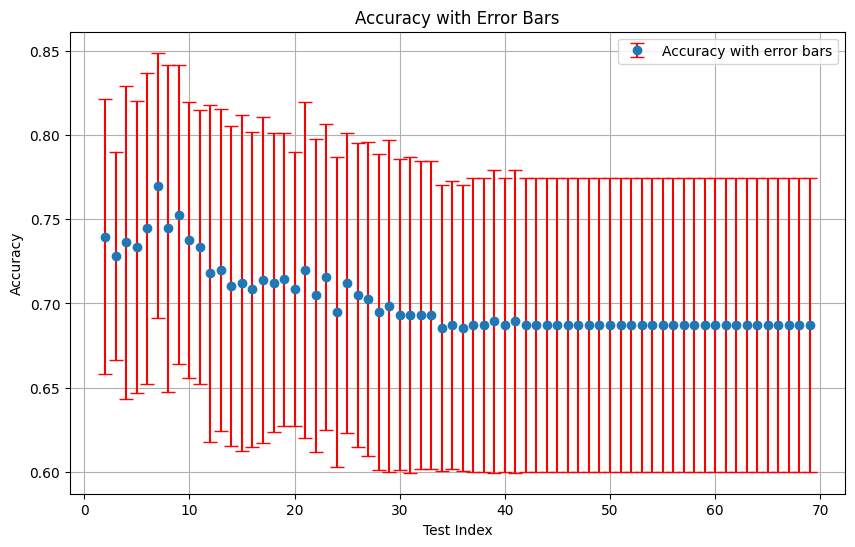

Max accuracy:  0.7700072909546595 Nb of neighbours for max accuracy:  7


In [431]:
import matplotlib.pyplot as plt
import numpy as np

accuracies = []
std = []
#nb_neighbours = []
nb_neurons = []
for j in range(2,70):
    score_list, accuracy_list, std_list = accuracy_std_kfold(dict_df, j)
    accuracies.append(np.mean(accuracy_list))
    std.append(np.mean(std_list))
    #nb_neighbours.append(j)
    nb_neurons.append(j)

# Tracer le diagramme avec barres d'erreur
plt.figure(figsize=(10, 6))
#plt.errorbar(nb_neighbours, accuracies, yerr=std, fmt='o', ecolor='r', capsize=5, label='Accuracy with error bars')
plt.errorbar(nb_neurons, accuracies, yerr=std, fmt='o', ecolor='r', capsize=5, label='Accuracy with error bars')
# Ajouter des labels et un titre
plt.xlabel('Test Index')
plt.ylabel('Accuracy')
plt.title('Accuracy with Error Bars')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

index_of_max = nb_neurons[np.argmax(accuracies)]
print("Max accuracy: " , np.max(accuracies),"Nb of neighbours for max accuracy: ", index_of_max)


In [432]:
std[np.argmax(accuracies)]

0.07888112579564462

Ranking of the features based on the amplitude of the coefficients


In [47]:
model = LogisticRegression(max_iter=1000)
ranking_df = pd.DataFrame()
for i in subject_numbers:
# Entraînement du modèle sur l'ensemble des données pour obtenir les coefficients
    model.fit(dict_df[f'sub_0{i}'][0], dict_df[f'sub_0{i}'][1])

    # Affichage des coefficients les plus importants
    coefficients = model.coef_[0]  # Pour la régression logistique binaire
    importance = np.abs(coefficients)

    # Affichage des caractéristiques et de leur importance relative, triées par importance
    features_importance = sorted(zip(dict_df[f'sub_0{i}'][0].columns, importance), key=lambda x: x[1], reverse=True)
    print(features_importance)
    feature_ranked = [feature[0] for feature in features_importance]
    ranking_df[f'sub-0{i}'] = feature_ranked


ranking_df

[('ROI_25_mean', 1.1146010173440528), ('ROI_20_min', 0.8826032644755314), ('ROI_15_min', 0.8455341663629632), ('ROI_32_mean', 0.7618139390751129), ('ROI_29_std', 0.7199566951666942), ('ROI_36_min', 0.7042579336126453), ('ROI_31_mean', 0.6030836716299098), ('ROI_12_mean', 0.5904409769922027), ('ROI_31_std', 0.5568831276523601), ('ROI_47_min', 0.5545506666004896), ('ROI_29_mean', 0.5471081585449442), ('ROI_38_min', 0.543138952993759), ('ROI_13_min', 0.5401394588792329), ('ROI_18_mean', 0.4998306797947616), ('ROI_43_min', 0.4963210937486097), ('ROI_21_min', 0.485474256669957), ('ROI_33_min', 0.47438436587621996), ('ROI_21_mean', 0.4731333425875467), ('ROI_20_mean', 0.46663923146846054), ('ROI_13_mean', 0.4564401228799175), ('ROI_25_std', 0.44719650755855495), ('ROI_37_min', 0.4460757383645298), ('ROI_23_mean', 0.44101663798544183), ('ROI_18_min', 0.4358964888913013), ('ROI_38_mean', 0.43006901015709714), ('ROI_45_mean', 0.42846138724608474), ('ROI_6_mean', 0.42403829105157265), ('ROI_31_m

,sub-03,sub-05,sub-06,sub-07,sub-08
0,ROI_25_mean,ROI_43_min,ROI_15_std,ROI_25_mean,ROI_39_mean
1,ROI_20_min,ROI_23_mean,ROI_20_min,ROI_31_min,ROI_44_min
2,ROI_15_min,ROI_46_min,ROI_20_mean,ROI_16_mean,ROI_38_mean
3,ROI_32_mean,ROI_22_min,ROI_44_min,ROI_18_min,ROI_5_mean
4,ROI_29_std,ROI_22_mean,ROI_33_min,ROI_43_min,ROI_40_mean
...,...,...,...,...,...
139,ROI_38_std,ROI_38_min,ROI_26_std,ROI_38_std,ROI_22_min
140,ROI_44_std,ROI_26_min,ROI_0_min,ROI_41_mean,ROI_40_min
141,ROI_4_mean,ROI_17_mean,ROI_40_min,ROI_35_min,ROI_26_std
142,ROI_21_std,ROI_2_mean,ROI_0_std,ROI_8_min,ROI_36_std


In [48]:
# Concatenate columns into a single series while keeping the same indices
concatenated = pd.concat([ranking_df[col] for col in ranking_df], ignore_index=False)

# Calculate the average of the indices for each unique feature value
mean_indices_for_features = concatenated.reset_index().groupby(0)['index'].mean()

# Sort results by the average of the indices, from lowest to highest
sorted_features_by_mean_index = mean_indices_for_features.sort_values()
features_ordered = sorted_features_by_mean_index.index
features_ordered


Index(['ROI_43_min', 'ROI_25_mean', 'ROI_23_mean', 'ROI_20_min', 'ROI_17_min',
       'ROI_18_min', 'ROI_15_min', 'ROI_31_mean', 'ROI_31_min', 'ROI_47_min',
       ...
       'ROI_40_min', 'ROI_38_std', 'ROI_19_mean', 'ROI_36_std', 'ROI_27_std',
       'ROI_2_mean', 'ROI_21_std', 'ROI_40_std', 'ROI_27_min', 'ROI_26_std'],
      dtype='object', name=0, length=144)

In [49]:
def mean_std_accuracy(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        model = LogisticRegression(max_iter=1000)
        #model = GradientBoostingClassifier(n_estimators=130, learning_rate=0.05, max_depth=1, random_state=0)
        #model = AdaBoostClassifier(n_estimators=100, learning_rate=0.005, random_state=0)
        #model = GaussianNB()
        #model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, use_label_encoder=False, eval_metric='mlogloss')
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1] -1, cv=kf, scoring='accuracy')
        score_list.append(scores)
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)

    return np.mean(accuracy_list), np.std(accuracy_list)

In [50]:
import copy
accuracies = []
features_used = []
std_acc =[]

for i in range(len(features_ordered)):
    features_to_use = features_ordered[:i+1]
    features_used.append(features_to_use[-1]) # Ajoute le nom de la dernière feature ajoutée
    dict_filtered = copy.deepcopy(dict_df)
    for sub in dict_filtered.values():
        sub[0] = sub[0][features_to_use]

    accuracy, std = mean_std_accuracy(dict_filtered)
    accuracies.append(accuracy)
    std_acc.append(std)

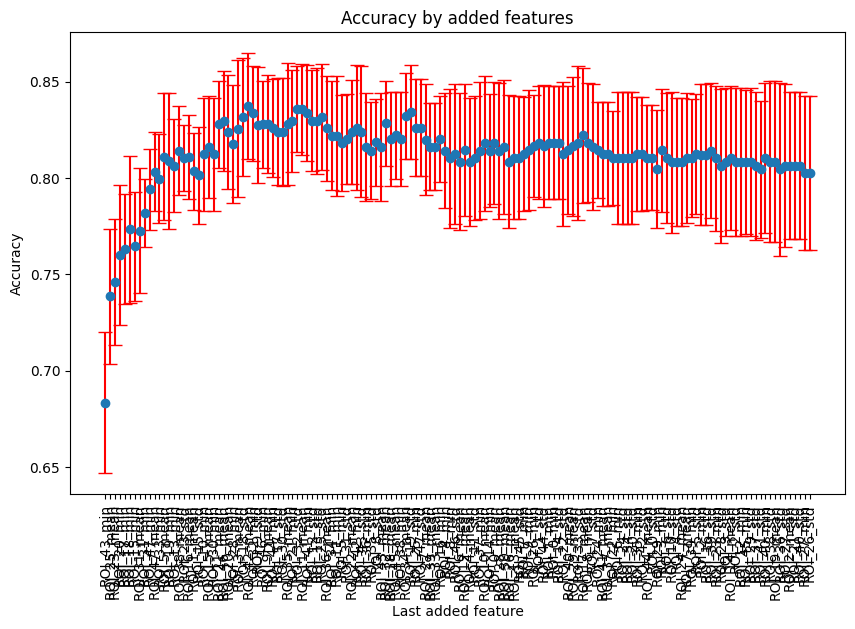

In [54]:
# Tracer l'accuracy en fonction du nombre de features
plt.figure(figsize=(10, 6))
plt.errorbar(features_used, accuracies, yerr=std_acc, fmt='o', ecolor='r', capsize=5, label='Accuracy with error bars')
plt.xlabel('Last added feature')
plt.ylabel('Accuracy')
plt.xticks(rotation=90) # Pour améliorer la lisibilité des labels sur l'axe des x
plt.title('Accuracy by added features')
plt.show()

In [61]:
max_acc = np.max(accuracies)
id_max =np.argmax(accuracies)
std_max_ac = std_acc[id_max]
print(max_acc, std_max_ac)
features_used[:id_max]

0.837442697653224 0.027393510660716804


['ROI_43_min',
 'ROI_25_mean',
 'ROI_23_mean',
 'ROI_20_min',
 'ROI_17_min',
 'ROI_18_min',
 'ROI_15_min',
 'ROI_31_mean',
 'ROI_31_min',
 'ROI_47_min',
 'ROI_47_mean',
 'ROI_33_min',
 'ROI_5_mean',
 'ROI_19_min',
 'ROI_13_min',
 'ROI_38_mean',
 'ROI_23_std',
 'ROI_16_mean',
 'ROI_1_mean',
 'ROI_15_std',
 'ROI_10_min',
 'ROI_15_mean',
 'ROI_30_min',
 'ROI_21_mean',
 'ROI_46_mean',
 'ROI_20_mean',
 'ROI_28_min',
 'ROI_3_mean',
 'ROI_18_std']

Let's train a single model on the 5 subjects using the Leave One out method

In [34]:
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb



#Here with other classifiers

loo = LeaveOneOut()
scores = []

# Concatenate all data into a single matrix
X_total = np.concatenate([dict_df[sub][0] for sub in dict_df], axis=0)
y_total = np.concatenate([dict_df[sub][1] for sub in dict_df], axis=0)

# Index to track topic datasets
indices = np.concatenate([[i] * len(dict_df[sub][1]) for i, sub in enumerate(dict_df)])

nb_neurons = []
accuracies_neurons = []

# Leave-One-Out cross-validation loop on topics
for train_subs, test_sub in loo.split(dict_df):
    # Selection of training and testing data based on topics
    X_train, X_test = X_total[indices != test_sub], X_total[indices == test_sub]
    y_train, y_test = y_total[indices != test_sub], y_total[indices == test_sub]
    
    # Model creation and training
    model = KNeighborsClassifier(n_neighbors=25)
    model.fit(X_train, y_train)
    
    # Prediction and evaluation
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    scores.append(score)

# Calculation of average accuracy on all subjects
accuracy_moyenne = np.mean(scores)
std = np.std(scores)
print(f"Accuracy moyenne en LOO sur les sujets : {accuracy_moyenne}\n"
      f"Standard deviation : {std}")




Accuracy moyenne en LOO sur les sujets : 0.7735858874294055
Standard deviation : 0.036454684205594876


c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


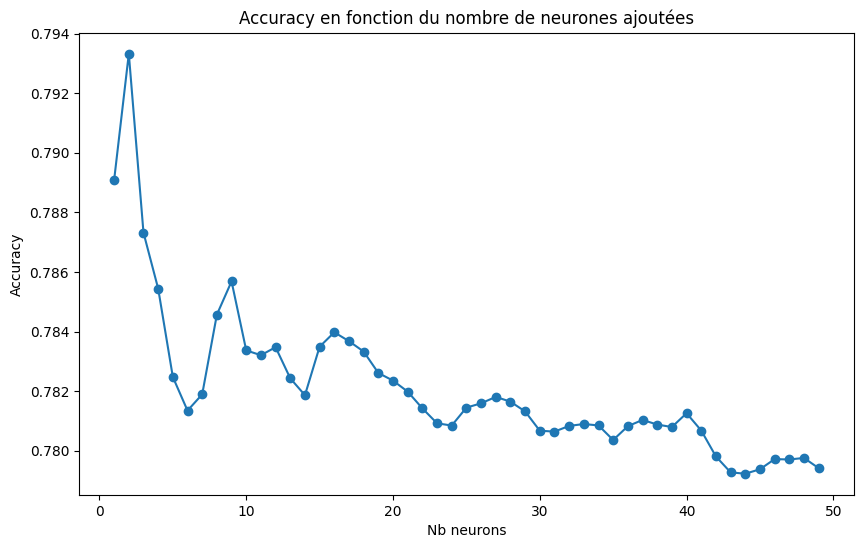

In [62]:
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#Here with MLP, try to find the optimized number of neurons

loo = LeaveOneOut()
scores = []

# Concatenate all data into a single matrix
X_total = np.concatenate([dict_df[sub][0] for sub in dict_df], axis=0)
y_total = np.concatenate([dict_df[sub][1] for sub in dict_df], axis=0)

# Index to track topic datasets
indices = np.concatenate([[i] * len(dict_df[sub][1]) for i, sub in enumerate(dict_df)])

nb_neurons = []
accuracies_neurons = []
for i in range (1,50):
# Leave-One-Out cross-validation loop on topics
    for train_subs, test_sub in loo.split(dict_df):
        # Selection of training and testing data based on topics
        X_train, X_test = X_total[indices != test_sub], X_total[indices == test_sub]
        y_train, y_test = y_total[indices != test_sub], y_total[indices == test_sub]
        
        # Model creation and training
        #model = KNeighborsClassifier(n_neighbors=i)
        model = MLPClassifier(random_state=42, hidden_layer_sizes=(i,), max_iter=1000)
        model.fit(X_train, y_train)
        
        # Prediction and evaluation
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions)
        scores.append(score)

    # Calculation of average accuracy on all subjects
    accuracy_moyenne = np.mean(scores)
    #print(f"Accuracy moyenne en LOO sur les sujets : {accuracy_moyenne}")
    nb_neurons.append(i)
    accuracies_neurons.append(accuracy_moyenne)

plt.figure(figsize=(10, 6))
plt.plot(nb_neurons, accuracies_neurons, marker='o')
plt.xlabel('Nb neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction du nombre de neurones ajoutées')
plt.show()


In [29]:
np.argmax(accuracies_neurons[:50])

24

In [31]:
nb_neurons[24]

25

In [30]:
accuracies_neurons[24]

0.7654914313513972